# Neural Network Exercises
For these exercises we'll perform a binary classification on the Census Income dataset available from the <a href = 'http://archive.ics.uci.edu/ml/datasets/Adult'>UC Irvine Machine Learning Repository</a><br>
The goal is to determine if an individual earns more than $50K based on a set of continuous and categorical variables.

In [1]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
%matplotlib inline

In [2]:
df = pd.read_csv('income.csv')
df.head(10)

,age,sex,education,education-num,marital-status,workclass,occupation,hours-per-week,income,label
0,27,Male,HS-grad,9,Never-married,Private,Craft-repair,40,<=50K,0
1,47,Male,Masters,14,Married,Local-gov,Exec-managerial,50,>50K,1
2,59,Male,HS-grad,9,Divorced,Self-emp,Prof-specialty,20,<=50K,0
3,38,Female,Prof-school,15,Never-married,Federal-gov,Prof-specialty,57,>50K,1
4,64,Female,11th,7,Widowed,Private,Farming-fishing,40,<=50K,0
5,53,Male,Masters,14,Married,Private,Prof-specialty,40,>50K,1
6,23,Male,HS-grad,9,Married,Private,Handlers-cleaners,40,<=50K,0
7,52,Female,HS-grad,9,Widowed,Private,Craft-repair,40,<=50K,0
8,31,Male,HS-grad,9,Never-married,Private,Machine-op-inspct,40,<=50K,0
9,22,Female,HS-grad,9,Married,Private,Adm-clerical,40,<=50K,0


### 1. Separate continuous, categorical and label column names
You should find that there are 5 categorical columns, 2 continuous columns and 1 label.<br>
In the case of <em>education</em> and <em>education-num</em> it doesn't matter which column you use. For the label column, be sure to use <em>label</em> and not <em>income</em>.<br>
Assign the variable names "cat_cols", "cont_cols" and "y_col" to the lists of names.

In [3]:
cat_cols = ['sex', 'education', 'marital-status', 'workclass', 'occupation']
cont_cols = ['age', 'hours-per-week']
y_col = ['label']

### 2. Convert categorical columns to category dtypes

In [4]:
# Convert our three categorical columns to category dtypes.
for cat in cat_cols:
    df[cat] = df[cat].astype('category')

In [5]:
df.dtypes

age                  int64
sex               category
education         category
education-num        int64
marital-status    category
workclass         category
occupation        category
hours-per-week       int64
income              object
label                int64
dtype: object

In [6]:
# Shuffle the dataset (optional cos the data has already been shuffled)
# df = shuffle(df, random_state=101)
# df.reset_index(drop=True, inplace=True)
# df.head()

### 3. Set the embedding sizes

In [7]:
# This will set embedding sizes for Hours, AMvsPM and Weekdays
cat_szs = [len(df[col].cat.categories) for col in cat_cols]
emb_szs = [(size, min(50, (size+1)//2)) for size in cat_szs]
emb_szs

[(2, 1), (14, 7), (6, 3), (5, 3), (12, 6)]

### 4. Create an array of categorical values
Create a NumPy array called "cats" that contains a stack of each categorical column <tt>.cat.codes.values</tt><br>
Note: your output may contain different values. Ours came after performing the shuffle step shown above.

In [8]:
stack_list = []

for col in cat_cols:
    vals = df[col].cat.codes.values
    stack_list.append(vals)
    
cats = np.stack(stack_list, 1)
    
cats[:5]

array([[ 1, 10,  3,  2,  1],
       [ 1, 11,  1,  1,  2],
       [ 1, 10,  0,  3,  7],
       [ 0, 12,  3,  0,  7],
       [ 0,  1,  5,  2,  3]], dtype=int8)

### 5. Convert "cats" to a tensor
Convert the "cats" NumPy array to a tensor of dtype <tt>int64</tt>

In [9]:
cats = torch.tensor(cats, dtype=torch.int64)
# this syntax is ok, since the source data is an array, not an existing tensor

cats[:5]

tensor([[ 1, 10,  3,  2,  1],
        [ 1, 11,  1,  1,  2],
        [ 1, 10,  0,  3,  7],
        [ 0, 12,  3,  0,  7],
        [ 0,  1,  5,  2,  3]])

### 6. Create an array of continuous values
Create a NumPy array called "conts" that contains a stack of each continuous column.<br>
Note: your output may contain different values. Ours came after performing the shuffle step shown above.

In [11]:
stack_list = []

for col in cont_cols:
    vals = df[col].values
    stack_list.append(vals)
    
conts = np.stack(stack_list, 1)
    
conts[:5]

array([[27, 40],
       [47, 50],
       [59, 20],
       [38, 57],
       [64, 40]], dtype=int64)

### 7. Convert "conts" to a tensor
Convert the "conts" NumPy array to a tensor of dtype <tt>float32</tt>

In [12]:
conts = torch.tensor(conts, dtype=torch.float32)
# this syntax is ok, since the source data is an array, not an existing tensor

conts[:5]

tensor([[27., 40.],
        [47., 50.],
        [59., 20.],
        [38., 57.],
        [64., 40.]])

### 8. Create a label tensor
Create a tensor called "y" from the values in the label column. Be sure to flatten the tensor so that it can be passed into the CE Loss function.

In [32]:
y = torch.tensor(df[y_col].values).flatten()
y

tensor([0, 1, 0,  ..., 1, 0, 1])

In [33]:
y.shape

torch.Size([30000])

In [34]:
conts.shape

torch.Size([30000, 2])

In [35]:
cats.shape

torch.Size([30000, 5])

### 9. Create train and test sets from <tt>cats</tt>, <tt>conts</tt>, and <tt>y</tt>
We use the entire batch of 30,000 records, but a smaller batch size will save time during training.<br>
We used a test size of 5,000 records, but you can choose another fixed value or a percentage of the batch size.<br>
Make sure that your test records remain separate from your training records, without overlap.<br>
To make coding slices easier, we recommend assigning batch and test sizes to simple variables like "b" and "t".

In [36]:
b = 30000 # suggested batch size
t = 5000  # suggested test size

cat_train = cats[:b-t]
cat_test = cats[b-t:b]
con_train = conts[:b-t]
con_test = conts[b-t:b]
y_train = y[:b-t]
y_test = y[b-t:b]

### Define the model class
Run the cell below to define the TabularModel model class we've used before.

In [21]:
class TabularModel(nn.Module):

    def __init__(self, emb_szs, n_cont, out_sz, layers, p=0.5):
        # Call the parent __init__
        super().__init__()
        
        # Set up the embedding, dropout, and batch normalization layer attributes
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)
        
        # Assign a variable to hold a list of layers
        layerlist = []
        
        # Assign a variable to store the number of embedding and continuous layers
        n_emb = sum((nf for ni,nf in emb_szs))
        n_in = n_emb + n_cont
        
        # Iterate through the passed-in "layers" parameter (ie, [200,100]) to build a list of layers
        for i in layers:
            layerlist.append(nn.Linear(n_in,i)) 
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
        layerlist.append(nn.Linear(layers[-1],out_sz))
        
        # Convert the list of layers into an attribute
        self.layers = nn.Sequential(*layerlist)
    
    def forward(self, x_cat, x_cont):
        # Extract embedding values from the incoming categorical data
        embeddings = []
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
        x = torch.cat(embeddings, 1)
        # Perform an initial dropout on the embeddings
        x = self.emb_drop(x)
        
        # Normalize the incoming continuous data
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], 1)
        
        # Set up model layers
        x = self.layers(x)
        return x

### 10. Set the random seed
To obtain results that can be recreated, set a torch manual_seed (we used 33).

In [26]:
torch.manual_seed(33)

### 11. Create a TabularModel instance
Create an instance called "model" with one hidden layer containing 50 neurons and a dropout layer p-value of 0.4

In [27]:
model = TabularModel(emb_szs, conts.shape[1], 2, [50], p=0.4) # out_sz = 2

In [28]:
model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(2, 1)
    (1): Embedding(14, 7)
    (2): Embedding(6, 3)
    (3): Embedding(5, 3)
    (4): Embedding(12, 6)
  )
  (emb_drop): Dropout(p=0.4)
  (bn_cont): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=22, out_features=50, bias=True)
    (1): ReLU(inplace)
    (2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4)
    (4): Linear(in_features=50, out_features=2, bias=True)
  )
)

### 12. Define the loss and optimization functions
Create a loss function called "criterion" using CrossEntropyLoss<br>
Create an optimization function called "optimizer" using Adam, with a learning rate of 0.001

In [29]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### Train the model
Run the cell below to train the model through 300 epochs. Remember, results may vary!<br>
After completing the exercises, feel free to come back to this section and experiment with different parameters.

In [37]:
import time
start_time = time.time()

epochs = 300
losses = []

for i in range(epochs):
    i+=1
    y_pred = model(cat_train, con_train)
    loss = criterion(y_pred, y_train)
    losses.append(loss)
    
    # a neat trick to save screen space:
    if i%25 == 1:
        print(f'epoch: {i:3}  loss: {loss.item():10.8f}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print(f'epoch: {i:3}  loss: {loss.item():10.8f}') # print the last line
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:   1  loss: 0.65169734
epoch:  26  loss: 0.53827578
epoch:  51  loss: 0.46782774
epoch:  76  loss: 0.41664308
epoch: 101  loss: 0.37886703
epoch: 126  loss: 0.36081669
epoch: 151  loss: 0.34602949
epoch: 176  loss: 0.33354294
epoch: 201  loss: 0.32652661
epoch: 226  loss: 0.32358086
epoch: 251  loss: 0.31279573
epoch: 276  loss: 0.30870748
epoch: 300  loss: 0.30473346

Duration: 157 seconds


### 13. Plot the Cross Entropy Loss against epochs
Results may vary. The shape of the plot is what matters.

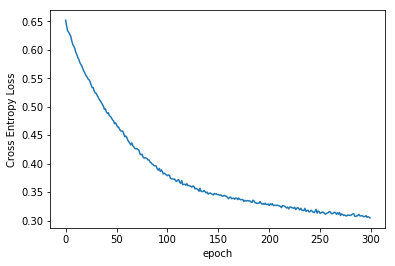

In [38]:
plt.plot(range(epochs), losses)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('epoch');

### 14. Evaluate the test set
With torch set to <tt>no_grad</tt>, pass <tt>cat_test</tt> and <tt>con_test</tt> through the trained model. Create a validation set called "y_val". Compare the output to <tt>y_test</tt> using the loss function defined above. Results may vary.

In [39]:
# TO EVALUATE THE ENTIRE TEST SET
with torch.no_grad():
    y_val = model(cat_test, con_test)
    loss = criterion(y_val, y_test)
print(f'CE Loss: {loss:.8f}')

CE Loss: 0.32016793


### 15. Calculate the overall percent accuracy
Using a for loop, compare the argmax values of the <tt>y_val</tt> validation set to the <tt>y_test</tt> set.

In [40]:
rows = 50
correct = 0
print(f'{"MODEL OUTPUT":26} ARGMAX  Y_TEST')
for i in range(rows):
    print(f'{str(y_val[i]):26} {y_val[i].argmax():^7}{y_test[i]:^7}')
    if y_val[i].argmax().item() == y_test[i]:
        correct += 1
print(f'\n{correct} out of {rows} = {100*correct/rows:.2f}% correct')

MODEL OUTPUT               ARGMAX  Y_TEST
tensor([-0.0848,  0.5582])    1      1   
tensor([ 0.4189, -0.2983])    0      0   
tensor([0.0398, 0.1038])      1      1   
tensor([ 3.0382, -3.7589])    0      0   
tensor([ 3.5302, -5.1911])    0      0   
tensor([ 1.0670, -0.7551])    0      0   
tensor([ 2.9056, -5.0878])    0      0   
tensor([ 0.4262, -1.4389])    0      0   
tensor([ 0.8905, -0.7903])    0      0   
tensor([ 1.6927, -2.5531])    0      0   
tensor([ 1.4493, -2.2909])    0      0   
tensor([-0.2854,  0.7559])    1      1   
tensor([ 0.2713, -0.2068])    0      1   
tensor([ 2.6384, -2.7133])    0      0   
tensor([ 2.9613, -3.1484])    0      0   
tensor([-0.7300,  0.6667])    1      1   
tensor([ 6.2551, -6.6035])    0      0   
tensor([0.1951, 0.5623])      1      0   
tensor([-0.2532, -0.0675])    1      1   
tensor([ 1.7866, -2.2391])    0      0   
tensor([ 1.8400, -2.6554])    0      0   
tensor([ 1.5601, -0.9895])    0      0   
tensor([ 1.7702, -2.0867])    0   

### BONUS: Feed new data through the trained model
See if you can write a function that allows a user to input their own values, and generates a prediction.<br>
<strong>HINT</strong>:<br>There's no need to build a DataFrame. You can use inputs to populate column variables, convert them to embeddings with a context dictionary, and pass the embedded values directly into the tensor constructors:<br>
<pre>mar = input("What is the person's marital status? ")
mar_d = dict(Divorced=0, Married=1, Married-spouse-absent=2, Never-married=3, Separated=4, Widowed=5)
mar = mar_d[mar]
cats = torch.tensor([..., ..., mar, ..., ...], dtype=torch.int64).reshape(1,-1)</pre>
Make sure that names are put in alphabetical order before assigning numbers.

Also, be sure to run <tt>model.eval()</tt> before passing new date through. Good luck!

In [42]:
def test_data(mdl): # pass in the name of the model
    # INPUT NEW DATA
    age = float(input("What is the person's age? (18-90)  "))
    sex = input("What is the person's sex? (Male/Female) ").capitalize()
    edn = int(input("What is the person's education level? (3-16) "))
    mar = input("What is the person's marital status? ").capitalize()
    wrk = input("What is the person's workclass? ").capitalize()
    occ = input("What is the person's occupation? ").capitalize()
    hrs = float(input("How many hours/week are worked? (20-90)  "))

    # PREPROCESS THE DATA
    sex_d = {'Female':0, 'Male':1}
    mar_d = {'Divorced':0, 'Married':1, 'Married-spouse-absent':2, 'Never-married':3, 'Separated':4, 'Widowed':5}
    wrk_d = {'Federal-gov':0, 'Local-gov':1, 'Private':2, 'Self-emp':3, 'State-gov':4}
    occ_d = {'Adm-clerical':0, 'Craft-repair':1, 'Exec-managerial':2, 'Farming-fishing':3, 'Handlers-cleaners':4,
            'Machine-op-inspct':5, 'Other-service':6, 'Prof-specialty':7, 'Protective-serv':8, 'Sales':9, 
            'Tech-support':10, 'Transport-moving':11}

    sex = sex_d[sex]
    mar = mar_d[mar]
    wrk = wrk_d[wrk]
    occ = occ_d[occ]

    # CREATE CAT AND CONT TENSORS
    cats = torch.tensor([sex,edn,mar,wrk,occ], dtype=torch.int64).reshape(1,-1)
    conts = torch.tensor([age,hrs], dtype=torch.float).reshape(1,-1)
    
    # SET MODEL TO EVAL (in case this hasn't been done)
    mdl.eval()

    # PASS NEW DATA THROUGH THE MODEL WITHOUT PERFORMING A BACKPROP
    with torch.no_grad():
        z = mdl(cats, conts).argmax().item()

    print(f'\nThe predicted label is {z}')
    

In [45]:
test_data(model)

What is the person's age? (18-90)  32
What is the person's sex? (Male/Female) male
What is the person's education level? (3-16) 12
What is the person's marital status? married
What is the person's workclass? private
What is the person's occupation? sales
How many hours/week are worked? (20-90)  40

The predicted label is 1
